# Carregar as bibliotecas

In [206]:
import numpy as np
from skimage import io, data, filters, util, color, transform, exposure, morphology, feature
from scipy import ndimage, stats, fft
import matplotlib.pyplot as plt
from skimage.util import img_as_float, img_as_uint, img_as_ubyte

In [207]:
def show(img_list, caption_list, Axis=False, rescale = True):
    n = len(img_list)
    f, ax = plt.subplots(1,n, figsize=(10+5*(n-1),10))
    for i in range(n):
        if rescale:
            ax[i].imshow(img_list[i], cmap='gray')
        else:
            ax[i].imshow(img_list[i], cmap='gray', vmin=0, vmax=255)
        ax[i].set_title(caption_list[i])
        if not Axis:
            ax[i].set_axis_off()

In [208]:
def gridFourier(M, N):
    u = np.arange(0, M)
    v = np.arange(0, N)

    u = u - np.floor(M/2)
    v = v - np.floor(N/2)
    U, V = np.meshgrid(u, v)
    return U, V

In [209]:
def mapping(img):
    nimg = util.img_as_float(img)
    mmin = np.min(nimg)
    nimg = nimg - mmin
    mmax = np.max(nimg)
    return (nimg/mmax)*255

In [210]:
def log_imshow(img):
    return np.log( np.abs(img)+1 )

In [211]:
def passa_freq(img, mask):
    height, width = img.shape[:2]
    fimg = fft.fftshift( fft.fft2(img) )
    fimg = fimg * mask
    nimg = fft.ifft2(fimg)
    nimg = np.abs(nimg)
    return nimg, fimg

# Questão 1

<p align="justify">
Dada a seguinte imagem, eliminar o ruído produzido pelo ruído periódico. Na figura abaixo é mostrado a imagem ruidosa e seu respectivo espectro de Fourier. Pode-se observar que existem dois pares de "spikes" (assinalados com a seta vermelha e amarela). Os ``spikes'' estão localizados nas coordenadas (36,10) e (72,-24). Utilize um filtro Notch Butterworth para apagar os coeficiente ao redor dos spikes.
</p>

<p align="justify">

</p>

<table><tr>
<td> <img src="https://drive.google.com/uc?id=10O_eu9WzBZzpTR1ila3R8wZ0SDzkM2kF" alt="Drawing"  width="300"/> </td>
<td> <img src="https://drive.google.com/uc?id=1cWr8WzFa6lHwyCFK1_iDOsrKu-lGqM1I" alt="Drawing"  width="300"/> </td>

</tr></table>



<p align"justify">
Filtro notch: São filtros capazes de rejeitar uma faixa bastante estreita de frequências. Sua utilização é recomendada quando o sinal a ser atenuado é bem definido. Pelo fato de atuar em faixas reduzidas de frequências, filtros notch interferem pouco na qualidade do sinal. A figura a continuação mostra apenas um par de regiões sendo retirado.
</p>

<img src="https://drive.google.com/uc?id=1L4J9Y6yFpKMebHyceWb1cy7j6CWljixO" alt="Drawing"  width="300"/>

<p align"justify">
A área em torno da frequência de corte escolhida ($D_0$) que pode ser retirada é definida na construção do filtro. Seja $D_0$ a frequência de corte do filtro notch centrado em ($u_0, v_0$) e, por simetria ($-u_0, -v_0$):

$$D_1(u,v) = \sqrt{(u - M/2 - u_0)^2 + (v - N/2 - v_0)^2}$$

$$D_2(u,v) = \sqrt{(u - M/2 + u_0)^2 + (v - N/2 + v_0)^2}$$

$$H(u,v) = \frac{1}{1 + \left(\frac{D_0^2}{D_1(u,v)D_2(u,v)}\right)^{2n}}$$

Crie um filtro notch para remover a ruído periódico
</p>


In [212]:
img = io.imread('https://drive.google.com/uc?id=10O_eu9WzBZzpTR1ila3R8wZ0SDzkM2kF')

In [213]:
def mask_butterworth_notch(width, height, d0, n, u, v):
    U, V = gridFourier(width, height)
    D1 = np.sqrt( (U-u)**2 + (V-v)**2 )
    D2 = np.sqrt( (U+u)**2 + (V+v)**2 )
    H = 1 / (1 + ( (d0**2)/(D1*D2) )**(2*n))
    return H

<ipython-input-213-7e58e33ee840>:5: RuntimeWarning: divide by zero encountered in divide
  H = 1 / (1 + ( (d0**2)/(D1*D2) )**(2*n))


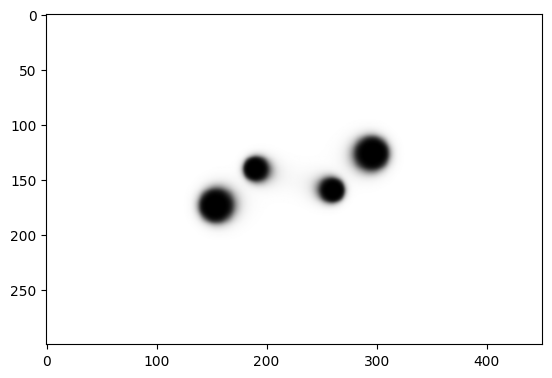

In [214]:
lin, col = img.shape[:2]
HN1 = mask_butterworth_notch(col, lin, 30, 4, 36, 10)
HN2 = mask_butterworth_notch(col, lin, 50, 4, 72,-24)
HN = HN1*HN2
plt.imshow(HN, cmap='gray',vmin=0, vmax=1)

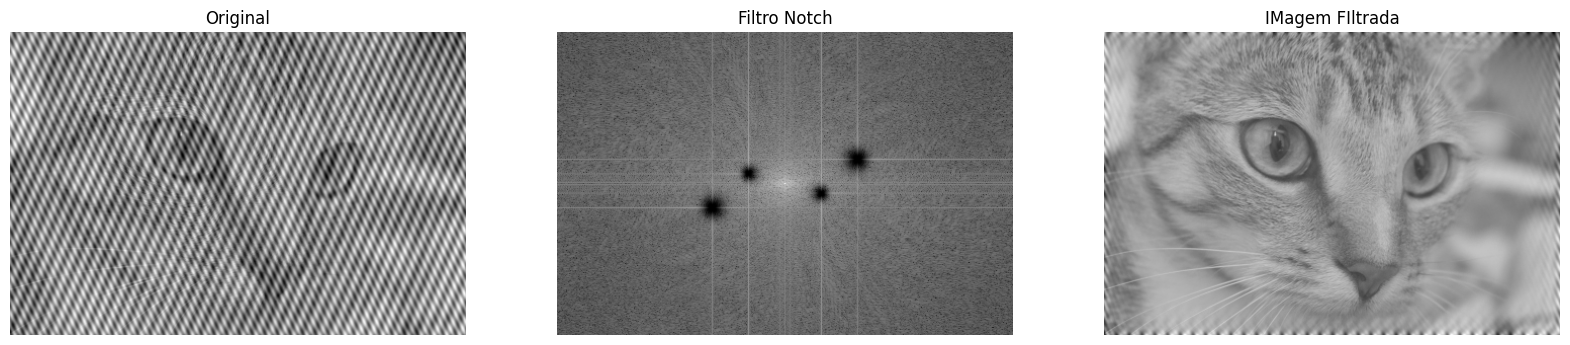

In [215]:
nimg, fimg = passa_freq(img, HN)
show([img, np.log(np.abs(fimg)+1), nimg], ['Original','Filtro Notch', 'IMagem FIltrada'])

# Questão 2
<p align="justify">
Repita o processo de remoção do ruído periódico da questão anterior utilizando os seguintes filtro passa-bandas: ideal, Butterworth e Gaussiano.
<p>

<p align="justify">
Filtro Ideal:
$$H(u,v) = \begin{cases}
0 & \text{se } D_0-\frac{W}{2} \leq D \leq D_0 + \frac{W}{2}\\
1 & \text{otherwise}
\end{cases} $$
<p>

<p align="justify">
Filtro Butterworth:
$$H(u,v) = \frac{1}{1 + \left(\frac{D.W}{D^2 - D_0^2}\right)^{2n}}$$
<p>

<p align="justify">
Filtro Gaussiano:
$$H(u,v) = 1 - e^{-  \left(\frac{D^2 - D_0^2}{D.W} \right)^2 }$$
<p>

In [216]:
def mask_ideal_band(width, height, d0, W):
    U, V = gridFourier(width, height)
    D = np.sqrt(U**2 + V**2)
    H = np.logical_or(d0-W/2>=D, d0+W/2<=D)
    return H

In [217]:
def mask_butterworth_band(width, height, d0, n, W):
    U, V = gridFourier(width, height)
    D = np.sqrt(U**2 + V**2)
    H = 1 / (1 + ((D*W)/(D**2 - d0**2))**(2*n) )
    return H


In [218]:
def mask_gaussian_band(width, height, d0,  W):
    U, V = gridFourier(width, height)
    D = np.sqrt(U**2 + V**2)
    H = 1 - np.exp(-((D**2 - d0**2) / (D*W))**2)
    return H

#### Exemplo de funcionamento das máscaras

<ipython-input-218-609b7ccf50fe>:4: RuntimeWarning: divide by zero encountered in divide
  H = 1 - np.exp(-((D**2 - d0**2) / (D*W))**2)


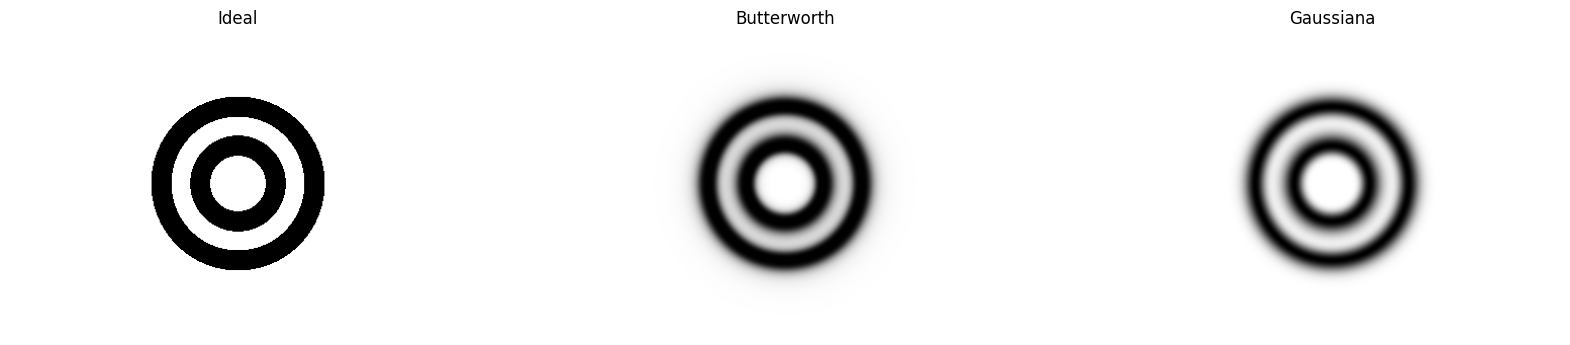

In [219]:
HI =  mask_ideal_band(col, lin, 75.89, 20)
H2 =  mask_ideal_band(col, lin, 37.36, 20)
Hc= HI * H2

HB =  mask_butterworth_band(col, lin, 75.89, 2, 20)
HB2 =  mask_butterworth_band(col, lin, 37.86, 2, 20)
HBc = HB * HB2

HG =  mask_gaussian_band(col, lin, 75.89, 20)
HG2 =  mask_gaussian_band(col, lin, 37.36, 20)
HGc = HG * HG2
show([Hc, HBc, HGc], ['Ideal','Butterworth', 'Gaussiana'])

<ipython-input-218-609b7ccf50fe>:4: RuntimeWarning: divide by zero encountered in divide
  H = 1 - np.exp(-((D**2 - d0**2) / (D*W))**2)


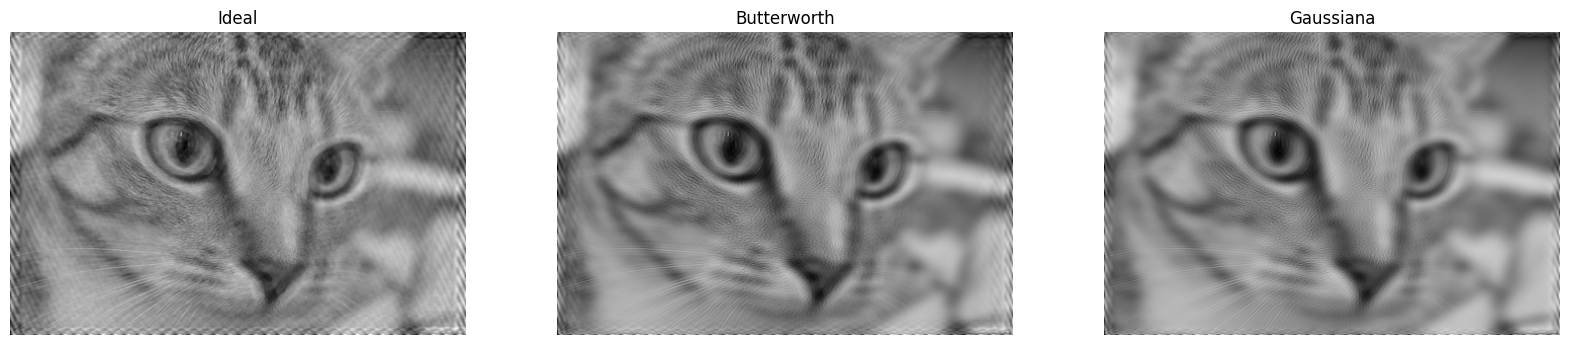

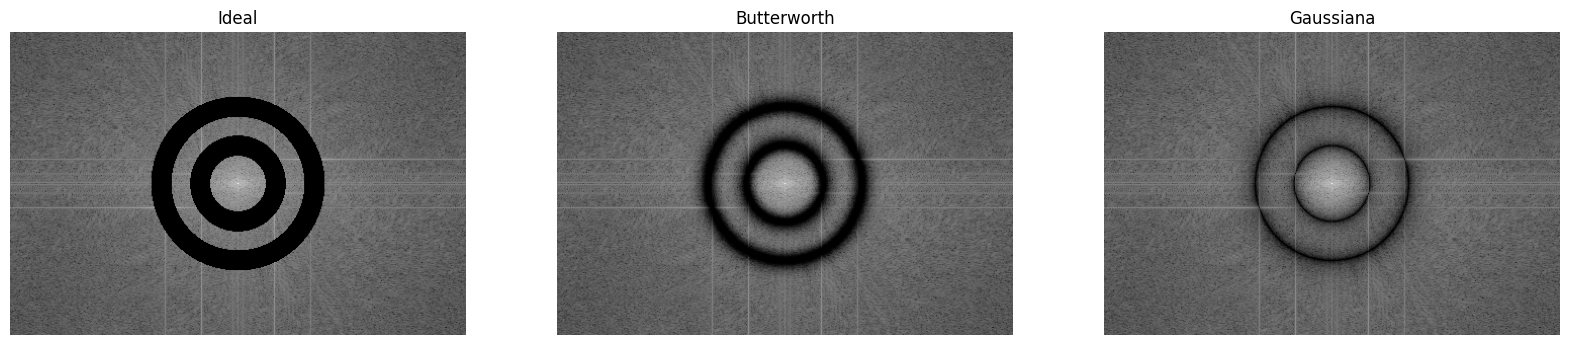

In [220]:
HI =  mask_ideal_band(col, lin, 75.89, 20)
H2 =  mask_ideal_band(col, lin, 37.36, 20)
Hc= HI * H2

HB =  mask_butterworth_band(col, lin, 75.89, 3, 30)
HB2 =  mask_butterworth_band(col, lin, 37.86, 3, 30)
HBc = HB * HB2

HG =  mask_gaussian_band(col, lin, 75.89, 45)
HG2 =  mask_gaussian_band(col, lin, 37.36, 45)
HGc = HG * HG2

nimgI, fimgI = passa_freq(img, Hc)
nimgB, fimgB = passa_freq(img, HBc)
nimgG, fimgG = passa_freq(img, HGc)

show([nimgI, nimgB, nimgG], ['Ideal','Butterworth', 'Gaussiana'])
show([np.log(np.abs(fimgI)+1), np.log(np.abs(fimgB)+1), np.log(np.abs(fimgG)+1)], ['Ideal','Butterworth', 'Gaussiana'])

## Questao 3

<p>
Crie uma nova versão da seguinte imagem aplicando a função <i>modifica</i>
</p>
<img src="https://drive.google.com/uc?id=1lWiT-Wz7ZFhWRf-u__aqxwzaho6AtLG8" alt="Drawing"  width="300"/>
<p>
Logo, binarize a nova imagem gerada usando um filtro adaptativo.
</p>

In [221]:
def modifica2(img):
  fimg = util.img_as_float(img, force_copy=True)
  lin, col = fimg.shape[:2]
  x = np.ones((lin,1)) @ np.arange(col).reshape(1,col)
  nimg = fimg * ( x/2 + 50 ) + (1-fimg) * x/2
  return mapping(nimg)

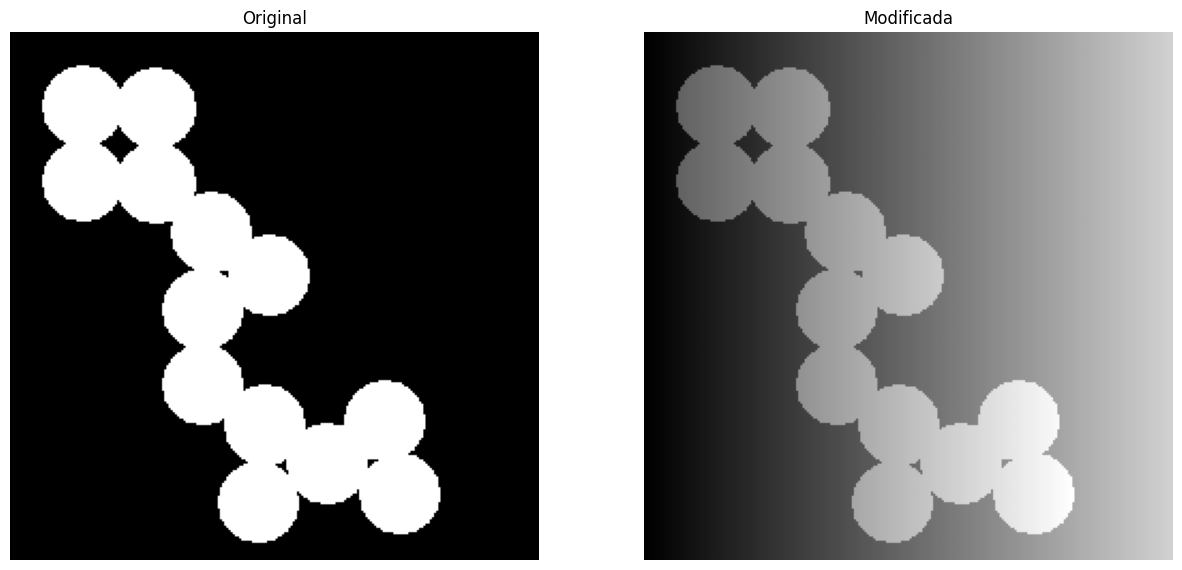

In [222]:
img = io.imread("https://drive.google.com/uc?id=1lWiT-Wz7ZFhWRf-u__aqxwzaho6AtLG8", as_gray=True)
nimg = modifica2(img)
show([img, nimg], ['Original', 'Modificada'])

### Aplica a segmentação em cada parte em que foi dividida a imagem

In [223]:
def segmentacao_adaptativa(img, blocos_x, blocos_y):
   width, height = img.shape
   nimg = np.zeros((width, height))
   x = np.linspace(0, width, blocos_x+1).astype(np.int64)
   y = np.linspace(0, height, blocos_y+1).astype(np.int64)
   for i in range(blocos_x):
    for j in range(blocos_y):
      thresh = filters.threshold_otsu(img[x[i]:x[i+1], y[j]:y[j+1]])
      nimg[x[i]:x[i+1], y[j]:y[j+1]] = img[x[i]:x[i+1], y[j]:y[j+1]] > thresh
   return nimg

In [224]:
def gridFourier(M, N):
    u = np.arange(0, M)
    v = np.arange(0, N)

    u = u - np.floor(M/2)
    v = v - np.floor(N/2)
    U, V = np.meshgrid(u, v)
    return U, V

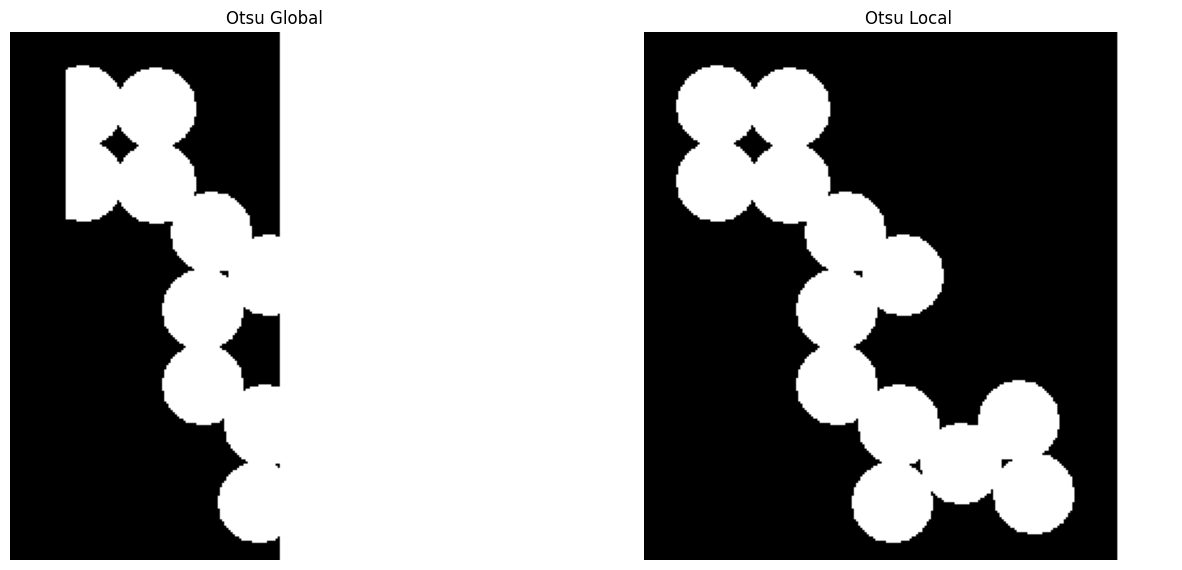

In [225]:
nimg2 = segmentacao_adaptativa(nimg, 1,5)
thresh = filters.threshold_otsu(nimg)
nimg3 = nimg > thresh
show([nimg3, nimg2], ['Otsu Global', 'Otsu Local'])

# Questão 4

<p>Encontre as bordas de uma imagem binaria através destas três técnicas de morfologia matemética</p>

<ol>
<li>Bordas internas: $A-(A \ominus B)$</li>
<li>Bordas externas: $(A \oplus B) - A$</li>
<li>Gradiente morfológico: $(A \oplus B) - (A \ominus B)$</li>
</ol>

A diferença lógica é definida da seguinte forma: $A - B = A \textrm{ and } (not B)$

In [226]:
from skimage import morphology

In [227]:
img = io.imread('https://drive.google.com/uc?id=1iB1pIbjzvA0pDxS0UqXsDEeZNe0wyrdT', as_gray=True)

In [228]:
def logical_difference(A, B):
  return np.logical_and(A, np.logical_not(B)).astype(np.uint8) # Converte para uint8 para exibir como imagem

<ipython-input-229-a4585f75e589>:1: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  edge_inner = logical_difference(img, morphology.erosion(img, morphology.square(3)))  # Bordas internas
<ipython-input-229-a4585f75e589>:2: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  edge_outer = logical_difference(morphology.dilation(img, morphology.square(3)), img)  # Bordas externas
<ipython-input-229-a4585f75e589>:3: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  edge_grad = logical_difference(morphology.dilation(img, morphology.square(3)), morphology.erosion(img, morphology.square(3)))  # Gradiente morfológico


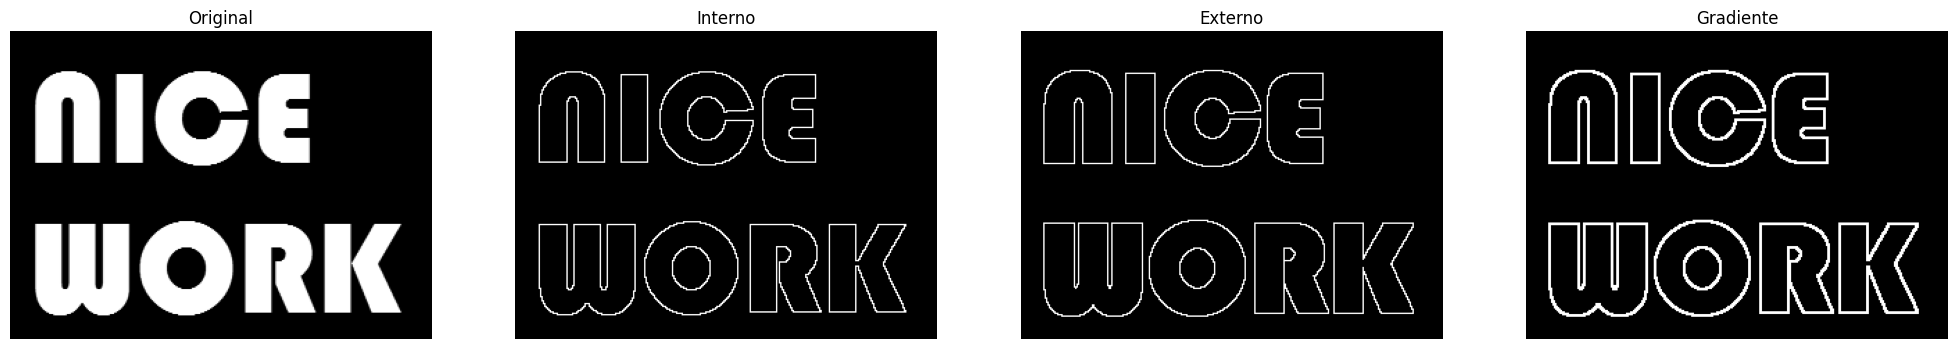

In [229]:
edge_inner = logical_difference(img, morphology.erosion(img, morphology.square(3)))  # Bordas internas
edge_outer = logical_difference(morphology.dilation(img, morphology.square(3)), img)  # Bordas externas
edge_grad = logical_difference(morphology.dilation(img, morphology.square(3)), morphology.erosion(img, morphology.square(3)))  # Gradiente morfológico

show([img, edge_inner, edge_outer, edge_grad],['Original', 'Interno', 'Externo', 'Gradiente'])

# Questão 5
<p align="justify">
Calcular os momentos de Hu das seguientes imagens. Logo, compare sua semelhança usado a similaridade de cossenos.
<p>

<p>A similaridade de cosseno é uma medida de similaridade entre dois vetores não nulos de um espaço de produto interno que mede o cosseno do ângulo entre eles.
A similaridade de cosseno entre os dois vetores é uma representação numérica de sua similaridade; varia de 0, que é completamente diferente, a 1, que é uma correspondência exata.</p>

<p>A similaridade de cossenos entre os sinais $A$ e $B$ é definida da seguinte forma:
$$\frac{\sum{A*B}}{\sqrt{\sum{A^2}} \sqrt{\sum{B^2}}}$$


<ol>
  <li>Implemente a função que calcule a similaridade de cossenos.</li>
  <li>Rotacione a imagem <i>A </i> em 30 e 60 graus. Logo, calcular os momentos de Hu das imagens A, A30 (rotação de A em 30 graus), A60 (rotação de A em 60 graus), B, V, e Bt (traslação de B).  Depois, determine a semelhança entre elas usando a função que calcula a similaridade de cossenos.</li>
</ol>
</p>



<table><tr>
<td> <img src="https://drive.google.com/uc?id=1h4QeEvRgB7wbAY9MocKGaaKDdniiQWQ6" alt="Drawing"  width="300"/> </td>
<td> <img src="https://drive.google.com/uc?id=1WV7pcoGXW6cJh74OjBwiD41gGcXfRMft" alt="Drawing"  width="300"/> </td>
<td> <img src="https://drive.google.com/uc?id=1soqJU7p5e59FBYBi1f5g34_4en8Q1e0k" alt="Drawing"  width="300"/> </td>
<td> <img src="https://drive.google.com/uc?id=1V5hZKGaQ-wlCjVnYgOG6WnnPih5nF7ET" alt="Drawing"  width="300"/> </td>
</tr></table>

In [230]:
from skimage import  measure

In [231]:
# Carregar as imagens
A = util.img_as_float( io.imread('https://drive.google.com/uc?id=1h4QeEvRgB7wbAY9MocKGaaKDdniiQWQ6', as_gray = True) )
B = util.img_as_float( io.imread('https://drive.google.com/uc?id=1WV7pcoGXW6cJh74OjBwiD41gGcXfRMft', as_gray = True) )
V = util.img_as_float( io.imread('https://drive.google.com/uc?id=1V5hZKGaQ-wlCjVnYgOG6WnnPih5nF7ET', as_gray = True) )
Bt = util.img_as_float( io.imread('https://drive.google.com/uc?id=1soqJU7p5e59FBYBi1f5g34_4en8Q1e0k', as_gray = True) )

#### Rotacionar a letra A em 30 e 60 graus

In [232]:
A_30 = transform.rotate(A, 30, resize=False, preserve_range=True) # Rotaciona a imagem 'A' em 30 graus
A_60 = transform.rotate(A, 60, resize=False, preserve_range=True) # Rotaciona a imagem 'A' em 60 graus
B_30 = transform.rotate(B, 30, resize=True, preserve_range=True) # Rotaciona a imagem 'B' em 30 graus

### Função que calcula a similaridade de cossenos

In [233]:
def cossine_sim(vecA, vecB):

  dot_product = np.sum(np.dot(vecA, vecB))
  magnitude_A = np.sqrt(np.sum(vecA**2))
  magnitude_B = np.sqrt(np.sum(vecB**2))

  # Verificação para evitar divisão por zero
  if magnitude_A == 0 or magnitude_B == 0:
    return 0  # Retorna 0 se a magnitude de algum vetor for 0
  else:
    similarity = dot_product / (magnitude_A * magnitude_B)
    return similarity

### Momentos de Hu

Podemos usar uma transformação log para colocar os 7 elementos  no mesmo intervalo

$$H_i = -sign(h_i) \log(|h_i|)$$

In [234]:
def sign_mom(h):
    epsilon = 1e-10  # Pequena constante para evitar log(0)
    return -np.sign(h) * np.log10(np.abs(h) + epsilon)

#### Função que calcula os momentos de Hu

In [235]:
def Hu_moments(img):
  momentos_centrais = measure.moments_central(img)
  momentos_normalizados = measure.moments_normalized(momentos_centrais)
  momentos_hu = measure.moments_hu(momentos_normalizados)
  return momentos_hu


#### Cálculo dos momentos das 6 imagens

In [236]:
A_mom = sign_mom(Hu_moments(A))
A_30_mom = sign_mom(Hu_moments(A_30))
A_60_mom = sign_mom(Hu_moments(A_60))
B_mom = sign_mom(Hu_moments(B))
V_mom = sign_mom(Hu_moments(V))
Bt_mom = sign_mom(Hu_moments(Bt))

#### Mostras as distancias entre os momentos de Hu das imagens

In [237]:
print(f'Dist(A,A30) = {cossine_sim(A_mom, A_30_mom)}')
print(f'Dist(A,A60) = {cossine_sim(A_mom, A_60_mom)}')
print(f'Dist(A,B) = {cossine_sim(A_mom, B_mom)}')
print(f'Dist(A,V) = {cossine_sim(A_mom, V_mom)}')
print(f'Dist(B,V) = {cossine_sim(V_mom, B_mom)}')
print(f'Dist(B,Bt) = {cossine_sim(B_mom, Bt_mom)}')

Dist(A,A30) = 0.999998397098785
Dist(A,A60) = 0.9999697997981903
Dist(A,B) = 0.3085653186753733
Dist(A,V) = 0.9984147263661403
Dist(B,V) = 0.31913509613688557
Dist(B,Bt) = 1.0000000000000002


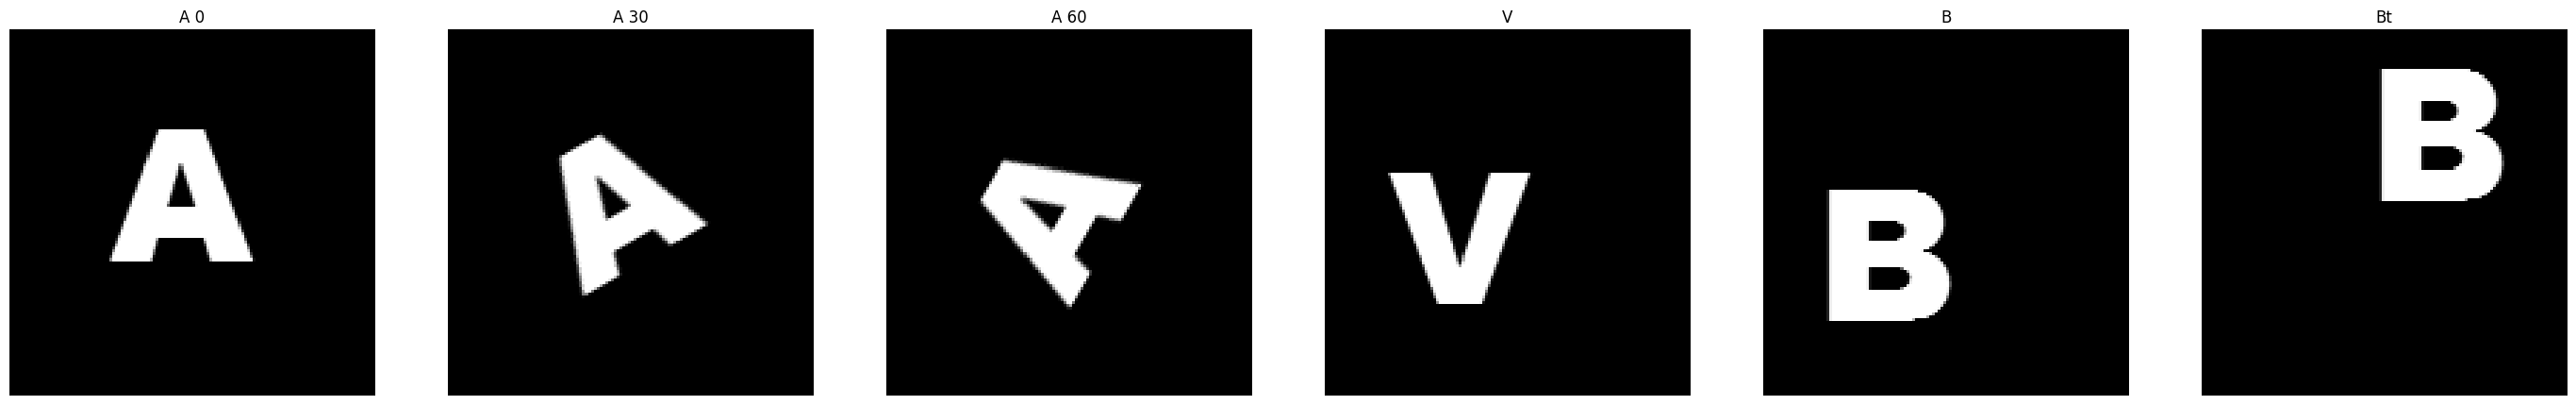

In [238]:
show([A, A_30, A_60, V, B, Bt],['A 0', 'A 30', 'A 60', 'V','B', 'Bt'])